In [1]:
""" First close look at eye tracking, statistics, heatmaps ,etc.

Is looking predictive of where draw?

"""

' First close look at eye tracking, statistics, heatmaps ,etc.\n\nIs looking predictive of where draw?\n\n'

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from neuralmonkey.classes.session import Session
import matplotlib.pyplot as plt
from neuralmonkey.scripts.load_and_save_locally import load_and_preprocess_single_session
import neuralmonkey.utils.monkeylogic as mkl
from neuralmonkey.classes.session import load_session_helper, load_mult_session_helper
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [3]:
DATE = 220606
DATE = 231116
# DATE = 220901
animal = "Pancho"

In [5]:
# DATE = 230630
# animal = "Diego"

In [4]:
save_dir = f'/data4/dan/saved_ms/{DATE}.pkl'
if not os.path.exists(save_dir):
    MS = load_mult_session_helper(DATE, animal)
    with open(save_dir,'wb') as f:
        pickle.dump(MS,f)
else:
    with open(save_dir,'rb') as f:
        MS = pickle.load(f)

TODO: Pancho -- combine circles with the tohers


# [GOOD] Clusterfix wrapper for extraction (written by Kedar)

### Extract from raw

In [7]:
# Notes, sanity checks of this code by me. Looking closely through:
# 1. extract_and_save_clusterfix_trial_xy_mats - DONE
# 2. self.extract_and_save_clusterfix_results_mat() - NOT DONE
# 3. self.extract_and_save_clusterfix_trial_fixsacc_csvs() - NOT DONE

# NOTE: sanity checka fter, pllotting results over raw , looks good.

In [ ]:
if False: # Make this "True" if you actualyl want to extract. This takes time...
    for sn in MS.SessionsList:
        sn.extract_and_save_clusterfix_results()

exporting xy mats...
trials, for computing a global offset to align tdt and ml2 eye tracking data: [24, 48, 75, 100, 125, 152, 177, 224, 249, 273, 298, 322, 347, 371, 397, 421, 447, 524, 548, 592, 616, 641, 701, 726, 750, 781, 810, 836, 866, 892]


KeyboardInterrupt: 

### First, sanity chekc that fixations from this dataset are closely preceded by saccades (~0.1 ms sacc durations). This is just for you, to be confident in extracted data.

In [5]:
sn = MS.SessionsList[0]

trial = sn.get_trials_list()[0]

##### Go thru all trials, and get global distribution over saccade durations

This fraction of saccades had duration longer than 0.2: 0.003878578068404013
Confirm by eye that most fixations are preceded by saccade less than ~150ms before it.
Trials with bad saccs (over 0.3s)
[22, 27, 34, 39, 46, 56, 64, 78, 88, 91, 92, 100, 105, 107, 129, 132, 137, 138, 143, 147, 166, 175, 180, 182, 207, 208, 209, 213, 215, 221, 222, 230, 238, 239, 243, 247, 254, 256, 271, 282, 283, 286, 290, 291, 294, 295, 306, 322, 326, 327, 330, 337, 350, 355, 360, 400, 411, 414, 420, 422, 423, 434, 448, 450, 512, 531, 537, 548, 574, 592, 597, 598, 599, 603, 606, 607, 613, 617, 619, 623, 625, 632, 645, 683, 684, 699, 720, 729, 731, 740, 741, 750, 758, 771, 776, 777, 782, 793, 806, 833, 835, 864, 878]
Fraction 0.1401360544217687


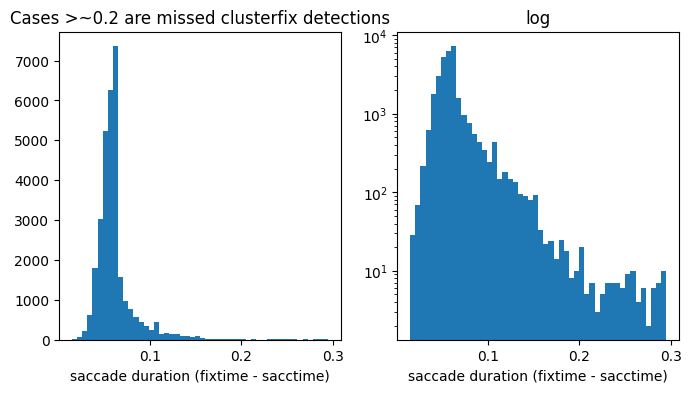

In [9]:
# Get fixation and saccade pairs
saccade_durations = []
trials_bad_saccs = []

for trial in sn.get_trials_list():
    times_fix, data_centroids = sn.events_get_clusterfix_fixation_times_and_centroids(trial)
    times_saccon =sn.events_get_clusterfix_saccade_times(trial, on_or_off=True)

    times_fix = np.array(times_fix)
    times_saccon = np.array(times_saccon)

    # inds_keep_fix = None
    # inds_keep_sacc = None
    inds_keep_fix = list(range(len(times_fix)))
    inds_keep_sacc = list(range(len(times_saccon)))
    if len(times_fix)==len(times_saccon):
        if times_fix[0] - times_saccon[0]>0:
            # good
            pass
        else:
            # shifted
            inds_keep_fix = inds_keep_fix[1:]
            inds_keep_sacc = inds_keep_sacc[:-1]
    elif len(times_fix)==len(times_saccon)+1:
        inds_keep_fix = inds_keep_fix[1:]
    elif len(times_fix)==len(times_saccon)-1:
        inds_keep_sacc = inds_keep_sacc[:-1]
    else:
        print(len(times_fix))
        print(len(times_saccon))
        print(times_fix)
        print(times_saccon)
        
        fig, ax = plt.subplots()
        ax.plot(times_saccon, times_fix, "ok")
        ax.plot([0, 10], [0, 10])

        assert False

    # take final 
    times_fix = times_fix[inds_keep_fix]
    times_saccon = times_saccon[inds_keep_sacc]

    
    # sanity check that fixations occur consistenyl and shortly after saccs
    assert len(times_saccon) == len(times_fix)
    assert np.all((times_fix - times_saccon)>0)
    if np.any((times_fix - times_saccon)>0.3):
    # this would be really bad. 
        trials_bad_saccs.append(trial)
        continue
    saccade_durations.extend(times_fix - times_saccon)
fig, axes = plt.subplots(1,2, figsize=(8,4))

ax=axes.flatten()[0]
ax.hist(saccade_durations, bins=50, log=False)
ax.set_xlabel("saccade duration (fixtime - sacctime)")
ax.set_title("Cases >~0.2 are missed clusterfix detections")

ax=axes.flatten()[1]
ax.hist(saccade_durations, bins=50, log=True)
ax.set_xlabel("saccade duration (fixtime - sacctime)")
ax.set_title("log")
MAX_SACC_DUR = 0.2
frac_toolong_saccades = sum(np.array(saccade_durations)>MAX_SACC_DUR)/len(saccade_durations)
print(f"This fraction of saccades had duration longer than {MAX_SACC_DUR}: {frac_toolong_saccades}")
np.max(times_fix - times_saccon)

print("Confirm by eye that most fixations are preceded by saccade less than ~150ms before it.")
print("Trials with bad saccs (over 0.3s)")
print(trials_bad_saccs)
print('Fraction',len(trials_bad_saccs)/len(sn.get_trials_list()))

### Assign each fixation to a shape x loc


trials, for computing a global offset to align tdt and ml2 eye tracking data: [24, 48, 75, 100, 125, 152, 177, 224, 249, 273, 298, 322, 347, 371, 397, 421, 447, 524, 548, 592, 616, 641, 701, 726, 750, 781, 810, 836, 866, 892]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[0.85743624]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[0.86171468]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.00633014]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.22598622]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[0.81129971]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.32765915]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.27090292]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the be

,idx_fixation,time_global,fix_cen,closest_task_token_dist,closest_task_token_idx,assigned_task_shape,assigned_task_gridloc,assigned_task_idx_task_orig,assigned_task_token,distance_to_each_token
0,0,3.070851,"[-63.075536580322925, -180.08737332427785]",453.938584,0,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,"{'orient_string': 'undef', 'shapeabstract': 'V...","{(-2, 1): 453.93858383979654}"
1,1,3.325914,"[238.8491994812202, -11.7030814052503]",468.377992,0,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,"{'orient_string': 'undef', 'shapeabstract': 'V...","{(-2, 1): 468.3779923699352}"
2,2,3.535967,"[-61.279649369490926, -151.4729378757478]",426.047104,0,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,"{'orient_string': 'undef', 'shapeabstract': 'V...","{(-2, 1): 426.0471040682446}"
3,3,3.886054,"[-124.81414293408908, 343.7609890725014]",8.486466,0,V-2-4-0,"(-2, 1)",0,"{'orient_string': 'undef', 'shapeabstract': 'V...","{(-2, 1): 8.486466257606311}"
4,4,4.106109,"[-139.27322064704987, 281.1995420455724]",3.306310,0,V-2-4-0,"(-2, 1)",0,"{'orient_string': 'undef', 'shapeabstract': 'V...","{(-2, 1): 3.306310141605558}"
5,5,4.281153,"[-112.02811226320216, 350.26863414184527]",3.555403,0,V-2-4-0,"(-2, 1)",0,"{'orient_string': 'undef', 'shapeabstract': 'V...","{(-2, 1): 3.5554026009043858}"


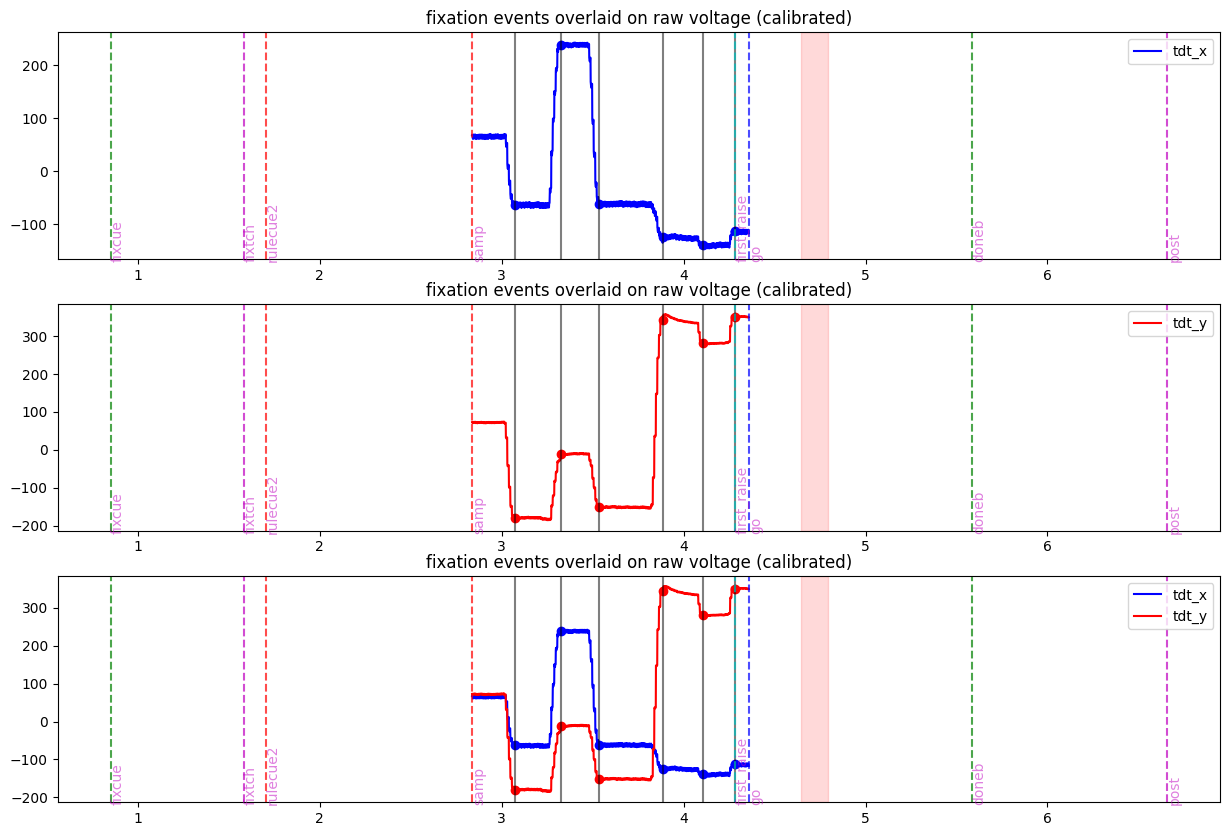

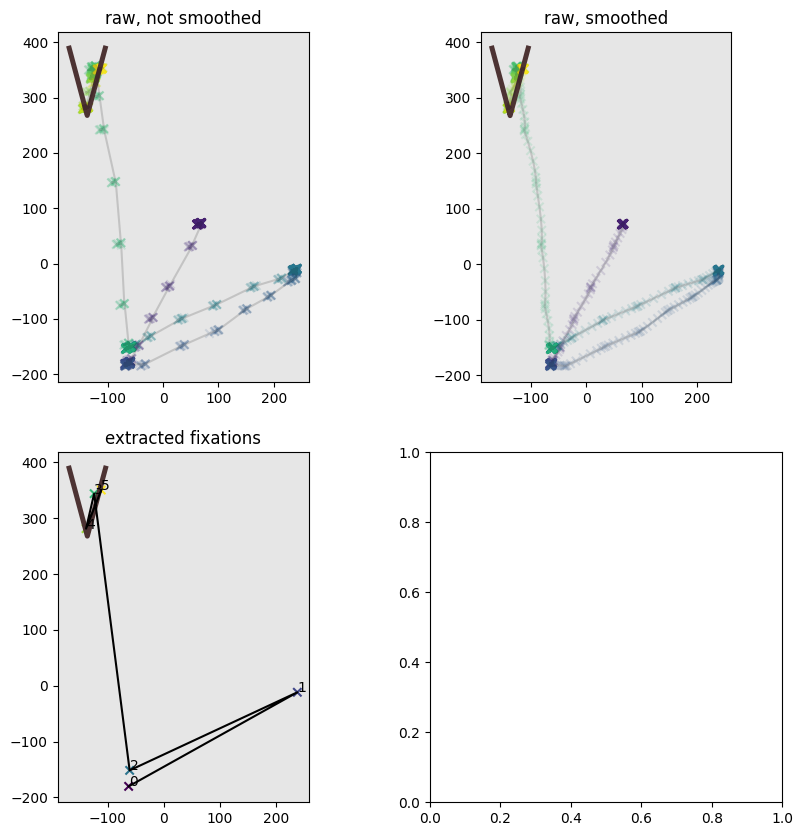

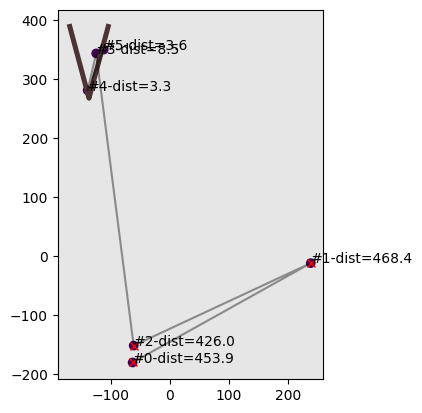

In [ ]:
# Run for a single trial, making example plots
trials = sn.get_trials_list()
trial = trials[1]
dffix = sn.beh_eye_fixation_extract_and_assign_task_shape(trial, event_endpoints=["stim_onset", "go"], PLOT=True)
display(dffix)

In [ ]:
for k, v in dffix["distance_to_each_token"].items():
    print(k, " --- ", v)

0  ---  {(-2, 1): 453.93858383979654}
1  ---  {(-2, 1): 468.3779923699352}
2  ---  {(-2, 1): 426.0471040682446}
3  ---  {(-2, 1): 8.486466257606311}
4  ---  {(-2, 1): 3.306310141605558}
5  ---  {(-2, 1): 3.5554026009043858}


In [ ]:
for k, v in dffix["distance_to_each_token"].items():
    print(k, " --- ", v)

0  ---  {(-2, 1): 453.93858383979654}
1  ---  {(-2, 1): 468.3779923699352}
2  ---  {(-2, 1): 426.0471040682446}
3  ---  {(-2, 1): 8.486466257606311}
4  ---  {(-2, 1): 3.306310141605558}
5  ---  {(-2, 1): 3.5554026009043858}


In [ ]:
# Collect across all data
trials = sn.get_trials_list()

list_df = []
for t in trials:
    print(t)
    dffix = sn.beh_eye_fixation_extract_and_assign_task_shape(t, event_endpoints=["stim_onset", "go"], PLOT=False)
    
    dffix["trialcode"] = sn.datasetbeh_trial_to_trialcode(t)
    
    list_df.append(dffix)
import pandas as pd
DFfix = pd.concat(list_df)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
67
68
69
70
71
72
73
74
75
76
77
78
79
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305

In [ ]:
print("All fixations: ")
display(DFfix)

All fixations: 


,idx_fixation,time_global,fix_cen,closest_task_token_dist,closest_task_token_idx,assigned_task_shape,assigned_task_gridloc,assigned_task_idx_task_orig,assigned_task_token,distance_to_each_token,trialcode
0,0,5.452559,"[-42.742878470023285, 115.01698852139052]",15.815195,0,V-2-4-0,"(0, 0)",0,"{'orient_string': 'undef', 'shapeabstract': 'V...","{(0, 0): 15.815194726473033}",231116-1-1
1,1,5.602611,"[-56.16249898947802, -179.56015464825222]",268.782781,0,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,"{'orient_string': 'undef', 'shapeabstract': 'V...","{(0, 0): 268.7827809403557}",231116-1-1
0,0,3.070851,"[-63.075536580322925, -180.08737332427785]",453.938584,0,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,"{'orient_string': 'undef', 'shapeabstract': 'V...","{(-2, 1): 453.93858383979654}",231116-1-2
1,1,3.325914,"[238.8491994812202, -11.7030814052503]",468.377992,0,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,"{'orient_string': 'undef', 'shapeabstract': 'V...","{(-2, 1): 468.3779923699352}",231116-1-2
2,2,3.535967,"[-61.279649369490926, -151.4729378757478]",426.047104,0,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,"{'orient_string': 'undef', 'shapeabstract': 'V...","{(-2, 1): 426.0471040682446}",231116-1-2
...,...,...,...,...,...,...,...,...,...,...,...
2,2,3.018285,"[266.28095763657967, 48.75488977671879]",248.296475,0,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,"{'orient_string': 'undef', 'shapeabstract': 'l...","{(1, -1): 248.2964751880737}",231116-1-893
3,3,3.318479,"[381.4644753406114, -70.34951597114696]",330.359208,0,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,"{'orient_string': 'undef', 'shapeabstract': 'l...","{(1, -1): 330.35920776945045}",231116-1-893
4,4,3.493592,"[-5.370364540770026, -105.27510337958708]",61.267128,0,line-8-4-0,"(1, -1)",0,"{'orient_string': 'undef', 'shapeabstract': 'l...","{(1, -1): 61.26712804377981}",231116-1-893
5,5,3.633682,"[-63.618424812556334, -168.45672388737083]",147.090887,0,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,"{'orient_string': 'undef', 'shapeabstract': 'l...","{(1, -1): 147.0908870877018}",231116-1-893


# To save, for Dolnik, removing custom classes

In [ ]:
DFfix = DFfix.drop(["assigned_task_token"], axis=1)


In [ ]:
path = f"/home/lucas/Dropbox/SCIENCE/FREIWALD_LAB/DATA/Dolnik/{animal}-{DATE}-fixations.pkl"
DFfix.to_pickle(path)

In [ ]:
DFfix

,idx_fixation,time_global,fix_cen,closest_task_token_dist,closest_task_token_idx,assigned_task_shape,assigned_task_gridloc,assigned_task_idx_task_orig,distance_to_each_token,trialcode
0,0,5.452559,"[-42.742878470023285, 115.01698852139052]",15.815195,0,V-2-4-0,"(0, 0)",0,"{(0, 0): 15.815194726473033}",231116-1-1
1,1,5.602611,"[-56.16249898947802, -179.56015464825222]",268.782781,0,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,"{(0, 0): 268.7827809403557}",231116-1-1
0,0,3.070851,"[-63.075536580322925, -180.08737332427785]",453.938584,0,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,"{(-2, 1): 453.93858383979654}",231116-1-2
1,1,3.325914,"[238.8491994812202, -11.7030814052503]",468.377992,0,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,"{(-2, 1): 468.3779923699352}",231116-1-2
2,2,3.535967,"[-61.279649369490926, -151.4729378757478]",426.047104,0,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,"{(-2, 1): 426.0471040682446}",231116-1-2
...,...,...,...,...,...,...,...,...,...,...
2,2,3.018285,"[266.28095763657967, 48.75488977671879]",248.296475,0,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,"{(1, -1): 248.2964751880737}",231116-1-893
3,3,3.318479,"[381.4644753406114, -70.34951597114696]",330.359208,0,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,"{(1, -1): 330.35920776945045}",231116-1-893
4,4,3.493592,"[-5.370364540770026, -105.27510337958708]",61.267128,0,line-8-4-0,"(1, -1)",0,"{(1, -1): 61.26712804377981}",231116-1-893
5,5,3.633682,"[-63.618424812556334, -168.45672388737083]",147.090887,0,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,FAR_FROM_ALL_SHAPES,"{(1, -1): 147.0908870877018}",231116-1-893


# Load and quick plots of eye

### (1) Neurally acquired eye tracking

In [ ]:
SN = MS.SessionsList[0]

In [ ]:
SN._CachedTrialOnset

In [ ]:
trials = SN.get_trials_list(True)
trials

In [ ]:
# SN.plot_stream(trial=trials[0], which="eyex")
SN.plot_stream(trial=trials[0], which="eyex")

### (2) Beh (monkeylogic) acquired eye data

In [ ]:
SN.load_behavior()

In [ ]:
# Developiung code to optimize alignment beween tdt and ml2.
times_tdt, vals_tdt, fs_tdt, times_ml2, vals_ml2, fs_ml2, fd = SN._beh_extract_eye_raw(100)
vals_tdt_calibrated = SN._beh_extract_eye_calibrate_raw(vals_tdt, fd)

SN._BehEyeAlignOffset = None

SN._beh_extract_eye_return_alignment_offset()

In [ ]:
%matplotlib inline
CHECK_TDT_ML2_MATCH = True
apply_empirical_offset = True
return_all = False
times_tdt, vals_tdt_calibrated = SN.beh_extract_eye_good(trials[100], CHECK_TDT_ML2_MATCH=CHECK_TDT_ML2_MATCH, PLOT=True, 
                                                         apply_empirical_offset=apply_empirical_offset, return_all=return_all)

In [ ]:
apply_empirical_offset = True
PLOT = False
CHECK_TDT_ML2_MATCH = True
for trial in SN.get_trials_list(True)[::10]:
    print(trial)
    times_tdt, vals_tdt_calibrated = SN.beh_extract_eye_good(trial, CHECK_TDT_ML2_MATCH=CHECK_TDT_ML2_MATCH, PLOT=PLOT, apply_empirical_offset=apply_empirical_offset)

### [FOR KEDAR] load eye tracking and plot over behavior

In [ ]:
def _plot_eye_trace(times, vals, ax, color="b"):
    ax.plot(vals[:,0], vals[:,1], "-k", alpha=0.3)
    ax.scatter(vals[:,0], vals[:,1], c=times, alpha=0.5, marker="o")    


In [ ]:
################ PARAMS
sn = MS.SessionsList[0]
PLOT_SM = True # smoothed?
trial = sn.get_trials_list(True)[-1]


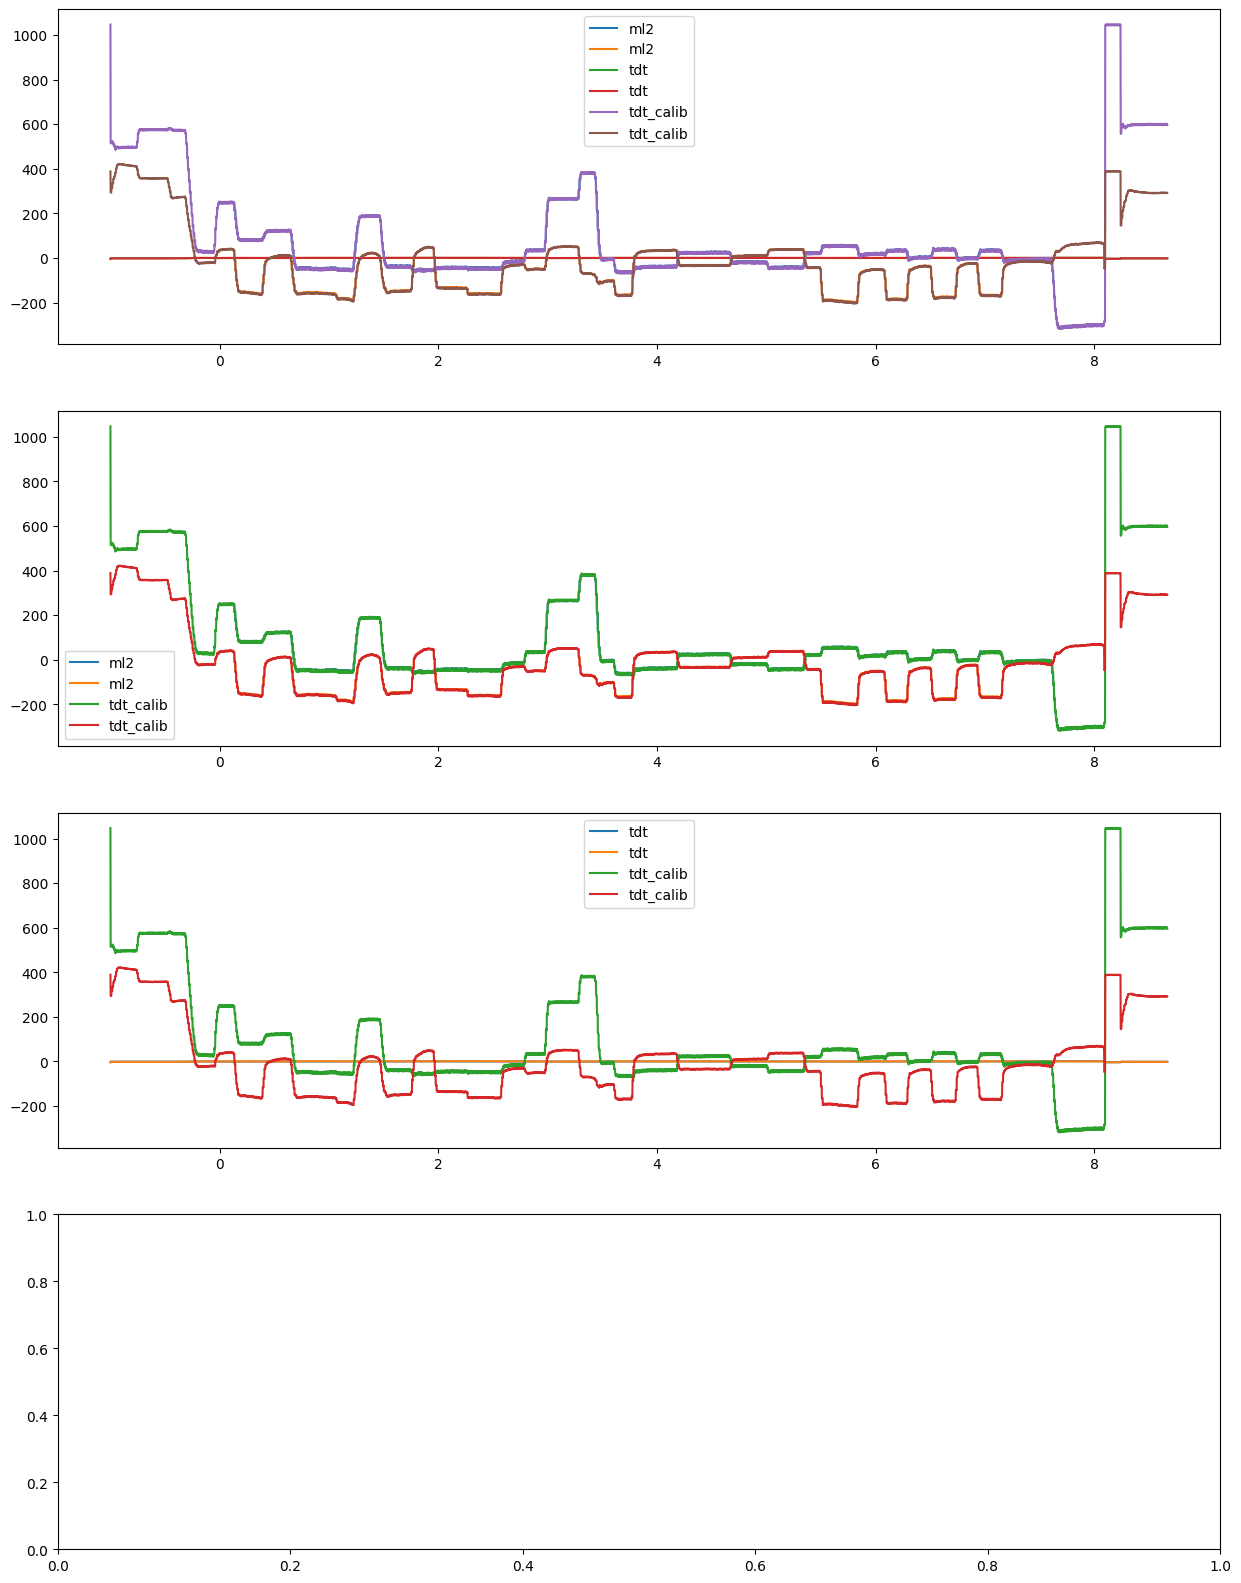

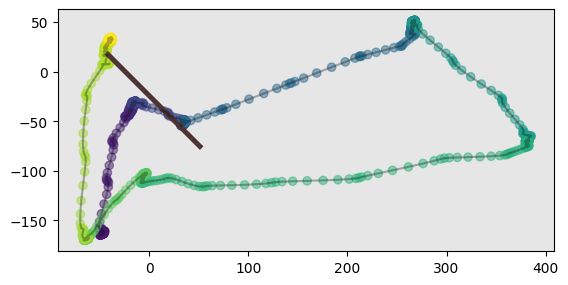

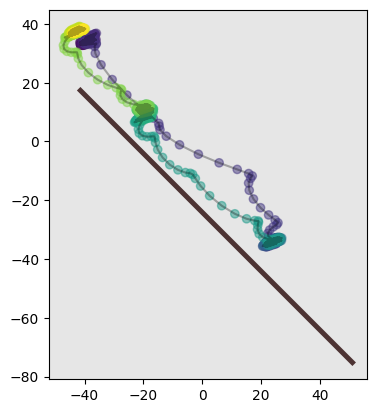

In [ ]:

############### RUN
times_tdt, vals_tdt_calibrated, fs_tdt, vals_tdt_calibrated_sm = sn.beh_extract_eye_good(trial, PLOT=True, return_all=True);

if PLOT_SM:
    VALS = vals_tdt_calibrated_sm
else:
    VALS = vals_tdt_calibrated
    
############### 1) Plot during planning
# Overlay on task and beh
fig, ax = plt.subplots()
sn.plot_taskimage(ax, trial)

# sn.Datasetbeh.plot_strokes([VALS], ax)
# _plot_eye_trace(VALS, ax, "r")

# keep just times during "planning"
dict_event_times = sn.events_get_time_sorted(trial)[0]
t1 = dict_event_times["stim_onset"]
t2 = dict_event_times["go"]

inds = (times_tdt>=t1) & (times_tdt<=t2)
times_this = times_tdt[inds]
vals_this = VALS[inds]

# sn.Datasetbeh.plot_strokes([vals_this], ax, single_color="r", alpha=0.5)
_plot_eye_trace(times_this, vals_this, ax)

############### 2) Plot during strokes
# Overlay on task and beh
fig, ax = plt.subplots()
sn.plot_taskimage(ax, trial)


dict_event_times = sn.events_get_time_sorted(trial)[0]
ons, offs = sn.strokes_extract_ons_offs(trial)
t1 = dict_event_times["go"]
t2 = offs[-1]

inds = (times_tdt>=t1) & (times_tdt<=t2)
times_this = times_tdt[inds]
vals_this = VALS[inds]

# sn.Datasetbeh.plot_strokes([vals_this], ax, single_color="r", alpha=0.5)
_plot_eye_trace(times_this, vals_this, ax)


In [ ]:
# Extract task stroke shapes, including their locations, etc.
ind = sn.datasetbeh_trial_to_datidx(trial)
tokens_task = sn.Datasetbeh.taskclass_tokens_extract_wrapper(ind, "task", plot=True)
tokens_beh = sn.Datasetbeh.taskclass_tokens_extract_wrapper(ind, "beh", plot=False)


In [ ]:
# Tokens holds each prim (either beh or task) as a discrete object

# This gives useful features for the first prim in the task
tokens_task[0]

In [ ]:
### to get times of events in the trial:
dict_event_times = sn.events_get_time_sorted(trial)

# - you can pick events form tjhis list:
print(sn.events_default_list_events())

# -- such as this:
dict_event_times = sn.events_get_time_sorted(trial, list_events=['samp', 'go', 'first_raise'])
print(dict_event_times)

### to get times of strokes
ons, offs = sn.strokes_extract_ons_offs(trial)
print(ons, offs)

In [ ]:
# To get spatial coordinates of task strokes
sn.strokes_task_extract(trial)

# [For Dan Hanuska] making single trial plots combining eye fixations, hand track, and drawing sequence (grammar)

In [ ]:
# Based on the plot I made with moment-by-moment decode and eye tracking overlaid.
# You can find that plot here: neuralmonkey.analyses.decodemoment.plot_single_trial_combine_signals_wrapper
# The below pulls out the essential stuff.

In [7]:
# from pythonlib.globals import PATH_HANDTRACK
expt = 'grampancho1'
PATH_HANDTRACK = f'/home/danhan/freiwaldDrive/dhanuska/handtrack_processed/{animal}/{DATE}_{expt}/processed_data.pkl'
with open (PATH_HANDTRACK, 'rb') as f:
    ht_dat_all = pickle.load(f)

from drawmonkey.tools.ht_preprocess import preprocess_merge
from pythonlib.tools.stroketools import strokesInterpolate2
ht_dat = preprocess_merge(ht_dat_all,'220914_f12_dlc')

for trial,d_trial in ht_dat.items():
    if d_trial['skipped'] is None:
            cam_fs = 1/np.mean(np.diff(d_trial['trans_pts_time_cam_all']))
            ht_dat[trial]['trans_pts_time_cam_all_int'] = strokesInterpolate2([d_trial['trans_pts_time_cam_all']],kind='linear',N=["fsnew",1000,cam_fs])[0]

from drawmonkey.tools.preprocess import loadSingleDataQuick, getSessionsList
fd = loadSingleDataQuick(animal,DATE,expt,1)

-- loaded presaved data: /home/danhan/freiwaldDrive/kgupta/macaque_data/Pancho/231116/231116_101721_grampancho1_Pancho_1.pkl


In [12]:
ht_dat[140].keys()

dict_keys(['strokes_cam', 'gaps_cam', 'pts_time_cam_all', 'strokes_touch', 'strokes_task', 'strokes_raw_times', 'likelihood_min', 'reg_strokes_cam', 'reg_gaps_cam', 'reg_pts_time_cam_all', 'trans_strokes_cam', 'trans_gaps_cam', 'trans_pts_time_cam_all', 'onset_offset_times', 'strokes_cam_calc_onoff', 'gaps_cam_calc_onoff', 'skipped', 'coefs_used'])

This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.22811337]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.33924297]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[0.98959213]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[0.90760191]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.79237131]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.73119646]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.04847277]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.27090292]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.31904795]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.13721633]
This is 10

/tmp/ipykernel_8618/4015628795.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(3, 1, figsize=(40, 20), sharex = True)


This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[0.94982536]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[0.88891922]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[0.94651033]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.42080958]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[0.74497808]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[0.79301143]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.28072387]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.35018408]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[0.96597484]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[0.92962924]
This is 10

/home/danhan/miniforge3/envs/pipe_dlc/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/danhan/miniforge3/envs/pipe_dlc/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: Input vector needs to be bigger than window size.

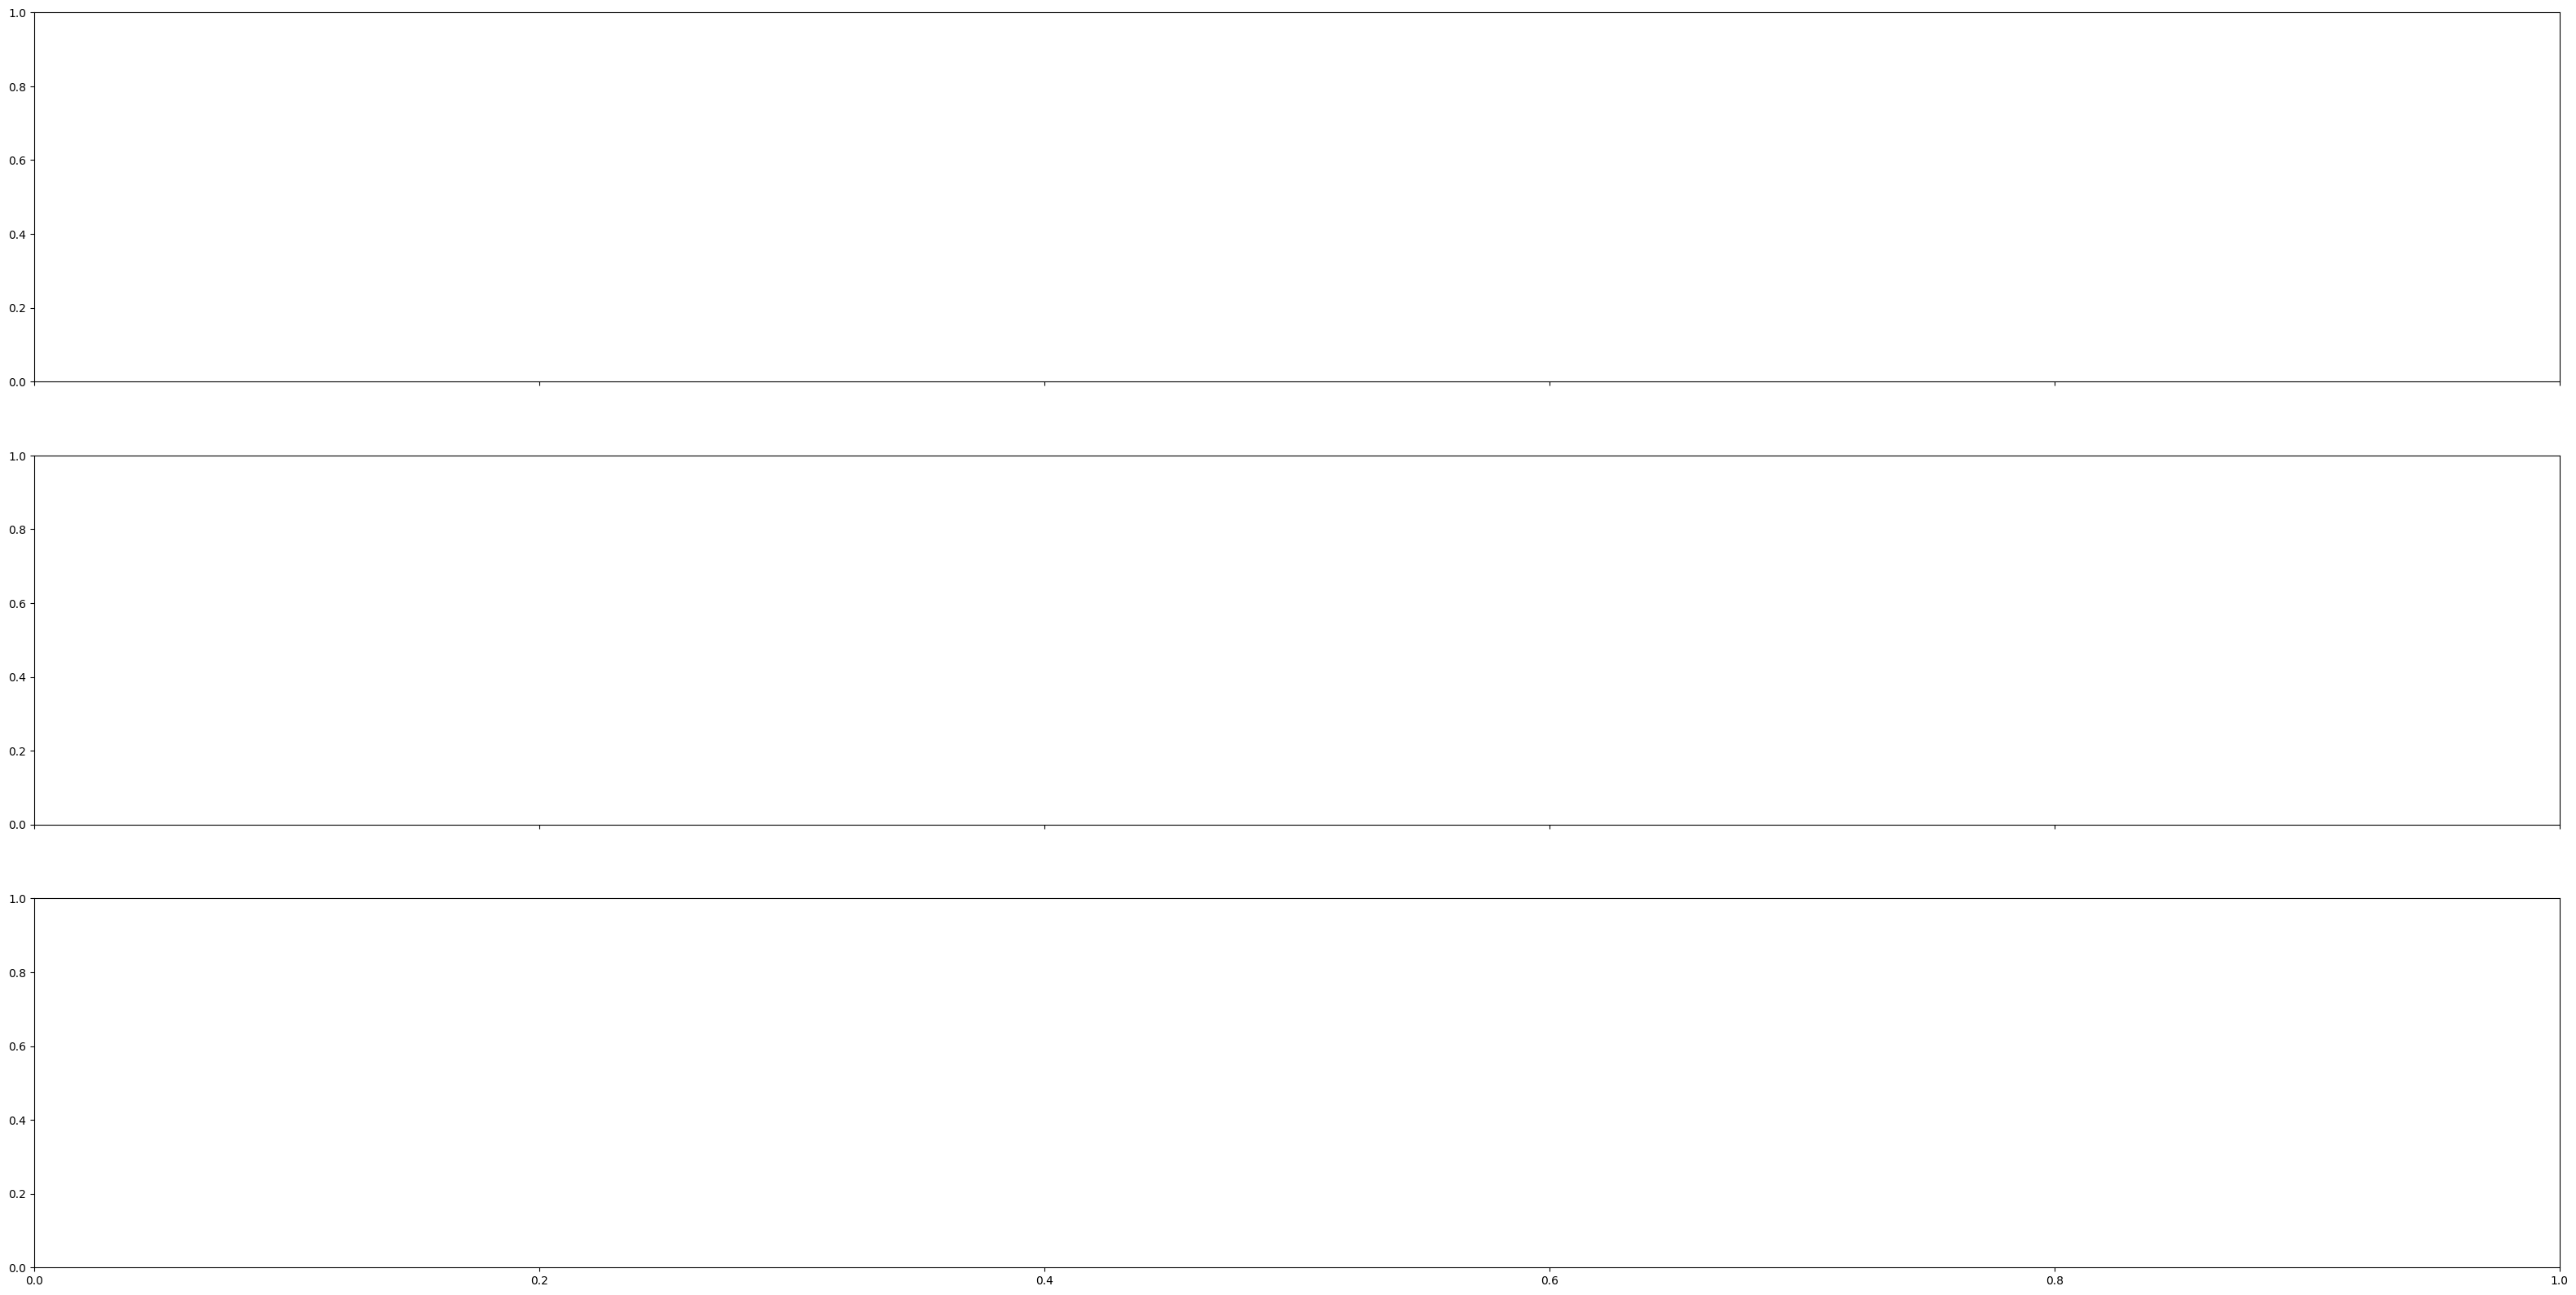

In [27]:
# Extract each kind of behavioral data
# - All will by default use identical timebases (behavior monkeylogic)
from pythonlib.tools.camtools import plotTrialsTrajectories
from drawmonkey.tools.utils import getTrialsStrokesByPeanuts 

### User input
# Take a ssession
SN = MS.SessionsList[0]

# Input a trial
trials = list(range(100,300))
fig_save_dir = f'/home/danhan/Documents/eyetrack_figs/{animal}/{DATE}'
os.makedirs(fig_save_dir,exist_ok=True)
for trial in trials:
    ### Runs
    fig, axes = plt.subplots(3, 1, figsize=(40, 20), sharex = True)

    ### (0) Plot handtrack data
    ax = axes.flatten()[0]
    pts_cam = ht_dat[trial]['trans_pts_time_cam_all']
    if ht_dat[trial+1]['skipped'] is not None or len(getTrialsStrokesByPeanuts(fd, trial))==0:
        #Skip trials with no HT data
        continue
    plotTrialsTrajectories(fd,ht_dat,trial,ax)
    dffix, map_shape_to_y, map_shape_to_col = SN.beh_eye_fixation_task_shape_overlay_plot(trial, ax, yplot=0)


    xmin,xmax = plt.xlim()

    ### (1) Plot eye tracking beh
    ax = axes.flatten()[1]
    # convert neural trial to trialcode
    trialcode = SN.datasetbeh_trial_to_trialcode(trial)

    # (1) Raw eye tracking (optional)
    SN.beh_plot_eye_raw_overlay_good(trial, ax)
    if False: # To get the raw
        CHECK_TDT_ML2_MATCH = True
        PLOT = False
        times_tdt, vals_tdt_calibrated = SN.beh_extract_eye_good(trials[100], CHECK_TDT_ML2_MATCH=CHECK_TDT_ML2_MATCH, PLOT=PLOT, 
                                                                apply_empirical_offset=apply_empirical_offset, return_all=return_all)

    # (2) Overlay events of interest
    SN.plotmod_overlay_trial_events(ax, trial)

    # (3) Eye fixations
    dffix, map_shape_to_y, map_shape_to_col = SN.beh_eye_fixation_task_shape_overlay_plot(trial, ax, yplot=-700)
    if False: # To get the raw
        dffix = DFfix[DFfix["trialcode"] == trialcode].reset_index(drop=True) 
        print("The fixation onsets and their beh labels: ")
        display(dffix.loc[:, ["idx_fixation", "time_global", "assigned_task_shape", "assigned_task_gridloc"]])

    # (3) Drawing sequence (grammar stuff)
    # TODO: Add in relevant code that works with D, from 250306_dataset_behavior_tutorial_dan.ipynb
    D = SN.Datasetbeh

    ### (2) Plot example nerual rasters
    ax = axes.flatten()[2]
    bregion = "preSMA"
    sites = SN.sitegetterKS_map_region_to_sites(bregion)
    SN.plot_raster_sites(ax, trial, sites, overlay_trial_events=True)

    # Plot a legend of what the eye track colors map to
    from pythonlib.tools.plottools import legend_add_manual
    # fig, ax = plt.subplots()
    legend_add_manual(ax, map_shape_to_col.keys(), map_shape_to_col.values())

    # (5) Plot the drawing and image
    sn.datasetbeh_plot_example_drawing(trial)
    plt.setp(ax, xlim=(xmin,xmax))
    fig.savefig(f'{fig_save_dir}/{trial}.png')
    plt.close('all')
